In [181]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pprint import pprint
import folium
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [57]:
class airbnb_city:
    
    def __init__(self, csv):
        
        self.csv = csv
                
        self.df_city = pd.read_csv(self.csv)
        
        print("Instance created!")
        
    def clean_columns(self):
        
        # Take only the relevant columns in the dataframe
        
        l_relevant_columns = ["host_is_superhost","neighbourhood_cleansed","neighbourhood_group_cleansed","property_type","room_type","accommodates","bathrooms_text","beds","price","minimum_nights","maximum_nights","availability_30","availability_365","number_of_reviews","instant_bookable", "amenities", "host_verifications"]

        self.df_city = self.df_city[l_relevant_columns]
        
        self.df_city["bathrooms_text"].replace(np.nan, "?", inplace = True)
        
        # Get numbers out of bathroom_text columns
        
        l_nums = [re.findall(r'\d+',i) for i in self.df_city["bathrooms_text"].values]

        l_nums_completed = []

        for i in l_nums:

            if len(i) > 1:

                l_nums_completed.append('.'.join(i))

            elif len(i) == 0:

                l_nums_completed.append('0')

            else:

                l_nums_completed.append(i[0])

        # Separate categories from bathroom_text
        
        l_category = []

        for i in self.df_city["bathrooms_text"].values:

            if "shared" in i:

                l_category.append("Shared")

            elif "private" in i:

                l_category.append("Private")

            else:

                l_category.append("Unknown")
                
        # Create two different columns replacing bathroom_text
        
        self.df_city.drop("bathrooms_text", axis = 1, inplace = True)
                
        self.df_city["num_of_baths"] = l_nums_completed
        
        self.df_city["bath_category"] = l_category
        
        self.df_city["num_of_baths"] = self.df_city["num_of_baths"].astype("float64")

        # Column["prices"]
        
        self.df_city["price"]  = self.df_city["price"] .apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x)
        
        self.df_city["amenities"] = [len(i) for i in self.df_city["amenities"]]

        self.df_city["host_verifications"] = [len(i) for i in self.df_city["host_verifications"]]
        
        
        print("Dataframe sucessfully created!")
    
    def label_encoding(self):
        
        self.df_city.dropna(inplace=True)
        
        # Encoding columns with dummies function
        
        def dummies(data, column):
            return pd.get_dummies(data = data[column], drop_first=True)
        
        self.df_city["host_is_superhost"] = dummies(self.df_city, "host_is_superhost")
        self.df_city["instant_bookable"] = dummies(self.df_city, "instant_bookable")
        
        df_room_type = dummies(self.df_city, "room_type")
        df_bath_category = dummies(self.df_city, "bath_category")
        df_bath_category = df_bath_category.rename(columns={'Shared': 'shared_bath', 'Unknown': 'unknoun_bath'})
        
        self.df_city = pd.concat([self.df_city, df_bath_category], axis = 1)

        self.df_city = pd.concat([self.df_city, df_room_type], axis = 1)

        self.df_city.drop("room_type", axis = 1, inplace = True)

        self.df_city.drop("bath_category", axis = 1, inplace = True)
        
        # Encoding categorical columns with labelEncoding function
        
        l_columns_to_labelEncode = ["neighbourhood_cleansed", "property_type", "neighbourhood_group_cleansed"]
        l_columns_encoded = list()

        for i in l_columns_to_labelEncode:

            # Inicializing object LabelEncoder()
            o_labelEncoding = LabelEncoder()

            # Training it with the column data
            o_labelEncoding.fit(self.df_city[i].values)

            # Transform the column
            l_columns_encoded.append(o_labelEncoding.transform(self.df_city[i].values))

        self.df_city["neighbourhood_cleansed"] = l_columns_encoded[0]
        self.df_city["property_type"] = l_columns_encoded[1]
        self.df_city["neighbourhood_group_cleansed"] = l_columns_encoded[2]
        
        print("Dataframe sucessfully encoded!")

        
    def return_df(self):
    
        return self.df_city
    
    def display_df(self):
    
        display(self.df_city)

In [152]:
madrid = airbnb_city("C:\\Users\\ignci\\OneDrive\\Escritorio\\Curso\\Coisigna\\dsb-p2-ml\\ipynbs\datasets\\Madrid air bnb\\listings_detailed.csv")

Instance created!


In [153]:
df = madrid.return_df()

In [154]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [160]:
df_columns_chosen = df[["host_id", "neighbourhood_group_cleansed", "latitude", "longitude", "room_type","accommodates", "price","minimum_nights","availability_365","number_of_reviews","calculated_host_listings_count", "reviews_per_month"]]

In [161]:
df_columns_chosen

,host_id,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,availability_365,number_of_reviews,calculated_host_listings_count,reviews_per_month
0,13660,Chamartín,40.45724,-3.67688,Private room,2,$60.00,1,180,78,1,0.58
1,83531,Latina,40.40381,-3.74130,Private room,1,$31.00,4,364,33,2,0.42
2,82175,Arganzuela,40.38840,-3.69511,Entire home/apt,6,$50.00,15,1,0,7,NaN
3,346366726,Centro,40.42183,-3.70529,Entire home/apt,3,$92.00,5,72,10,1,0.13
4,114340,Arganzuela,40.38975,-3.69018,Private room,1,$26.00,2,365,149,1,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...
19613,172011610,Centro,40.40756,-3.69937,Private room,1,$23.00,30,349,0,8,NaN
19614,172011610,Chamberí,40.43706,-3.71364,Private room,1,$21.00,30,350,0,8,NaN
19615,172011610,Chamberí,40.43857,-3.70715,Private room,1,$22.00,7,364,0,8,NaN
19616,172011610,Salamanca,40.43027,-3.66759,Private room,1,$19.00,30,349,0,8,NaN


In [162]:
df_columns_chosen = df_columns_chosen.dropna()

In [163]:
df_columns_chosen["price"]

0        $60.00
1        $31.00
3        $92.00
4        $26.00
5        $85.00
          ...  
19494    $44.00
19499    $37.00
19500    $70.00
19501    $47.00
19532    $70.00
Name: price, Length: 13981, dtype: object

In [164]:
df_columns_chosen["price"] = df_columns_chosen["price"].apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x).values

C:\Users\ignci\AppData\Local\Temp\ipykernel_8628\1023210409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columns_chosen["price"] = df_columns_chosen["price"].apply(lambda x: float(x.strip("$").replace(',', '')) if pd.notnull(x) else x).values


In [165]:
df_columns_chosen

,host_id,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,availability_365,number_of_reviews,calculated_host_listings_count,reviews_per_month
0,13660,Chamartín,40.45724,-3.67688,Private room,2,60.0,1,180,78,1,0.58
1,83531,Latina,40.40381,-3.74130,Private room,1,31.0,4,364,33,2,0.42
3,346366726,Centro,40.42183,-3.70529,Entire home/apt,3,92.0,5,72,10,1,0.13
4,114340,Arganzuela,40.38975,-3.69018,Private room,1,26.0,2,365,149,1,1.12
5,82175,Arganzuela,40.38860,-3.69492,Entire home/apt,6,85.0,1,365,3,7,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...
19494,4294898,Centro,40.42207,-3.69930,Entire home/apt,4,44.0,2,331,1,2,1.00
19499,18649792,Centro,40.42059,-3.70338,Entire home/apt,2,37.0,2,0,1,1,1.00
19500,236357316,Ciudad Lineal,40.43080,-3.65934,Entire home/apt,3,70.0,1,89,1,1,1.00
19501,394687867,Centro,40.42035,-3.70963,Entire home/apt,2,47.0,1,358,2,5,2.00


In [159]:
df_columns_chosen["property_type"].unique()

array(['Private room in apartment', 'Entire apartment',
       'Private room in house', 'Entire loft', 'Entire condominium',
       'Private room in guest suite', 'Private room in chalet',
       'Entire serviced apartment', 'Entire house',
       'Private room in condominium', 'Private room in bed and breakfast',
       'Private room in townhouse', 'Entire guest suite',
       'Shared room in apartment', 'Shared room in hut',
       'Room in aparthotel', 'Entire bungalow', 'Private room in loft',
       'Shared room in bed and breakfast', 'Dome house',
       'Shared room in loft', 'Casa particular', 'Shared room in hostel',
       'Private room', 'Private room in floor', 'Entire place',
       'Private room in casa particular', 'Room in serviced apartment',
       'Shared room in house', 'Room in boutique hotel',
       'Private room in guesthouse', 'Private room in hostel',
       'Room in hotel', 'Entire chalet', 'Entire bed and breakfast',
       'Private room in serviced apartmen

In [166]:
def dummies(data, column):
    return pd.get_dummies(data = data[column], drop_first=True)

In [167]:
df_room_type = dummies(df_columns_chosen, "room_type")

In [168]:
df_columns_chosen = pd.concat([df_columns_chosen, df_room_type], axis = 1)

In [169]:
df_columns_chosen.drop("room_type", axis = 1, inplace = True)

In [170]:
# Inicializing object LabelEncoder()
o_labelEncoding = LabelEncoder()

# Training it with the column data
o_labelEncoding.fit(df_columns_chosen["neighbourhood_group_cleansed"].values)

# Transform the column
neighbourhood_group_cleansed = o_labelEncoding.transform(df_columns_chosen["neighbourhood_group_cleansed"].values)


In [171]:
df_columns_chosen["neighbourhood_group_cleansed"] = neighbourhood_group_cleansed

In [172]:
df_columns_chosen

,host_id,neighbourhood_group_cleansed,latitude,longitude,accommodates,price,minimum_nights,availability_365,number_of_reviews,calculated_host_listings_count,reviews_per_month,Hotel room,Private room,Shared room
0,13660,4,40.45724,-3.67688,2,60.0,1,180,78,1,0.58,0,1,0
1,83531,9,40.40381,-3.74130,1,31.0,4,364,33,2,0.42,0,1,0
3,346366726,3,40.42183,-3.70529,3,92.0,5,72,10,1,0.13,0,0,0
4,114340,0,40.38975,-3.69018,1,26.0,2,365,149,1,1.12,0,1,0
5,82175,0,40.38860,-3.69492,6,85.0,1,365,3,7,0.03,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19494,4294898,3,40.42207,-3.69930,4,44.0,2,331,1,2,1.00,0,0,0
19499,18649792,3,40.42059,-3.70338,2,37.0,2,0,1,1,1.00,0,0,0
19500,236357316,6,40.43080,-3.65934,3,70.0,1,89,1,1,1.00,0,0,0
19501,394687867,3,40.42035,-3.70963,2,47.0,1,358,2,5,2.00,0,0,0


# Getting rid of outliers using quantiles

In [177]:
cols = ["price", "minimum_nights", "calculated_host_listings_count",
        "reviews_per_month", "number_of_reviews"]

for col in cols:
    upper_bound = df_columns_chosen[col].quantile(0.95)
    lower_bound = df_columns_chosen[col].quantile(0.05)
    listings = df_columns_chosen[df_columns_chosen[col] < upper_bound]
    listings = df_columns_chosen[df_columns_chosen[col] > lower_bound]

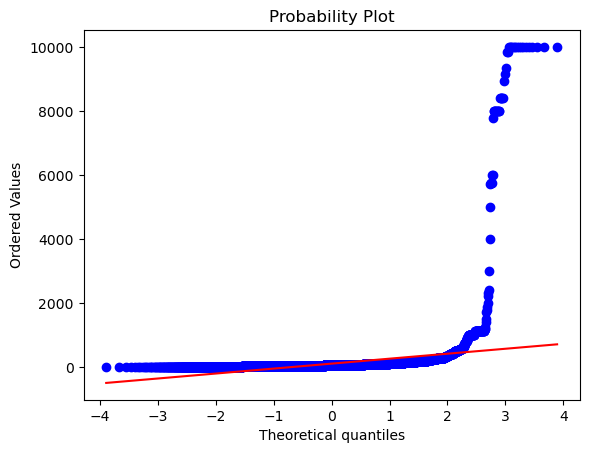

In [182]:
# Plot before transformation
stats.probplot(df_columns_chosen["price"], plot=plt)

# Power Transformer
numeric_cols = list(df_columns_chosen._get_numeric_data().columns)
pt = PowerTransformer(method="yeo-johnson")
df_columns_chosen[numeric_cols] = pt.fit_transform(df_columns_chosen[numeric_cols])

((array([-3.89265493, -3.67198108, -3.55103111, ...,  3.55103111,
          3.67198108,  3.89265493]),
  array([-3.33195413, -3.33195413, -3.08121355, ...,  3.56533681,
          3.56533681,  3.56533681])),
 (0.99757127752642, -3.246289870522459e-16, 0.9973076543913555))

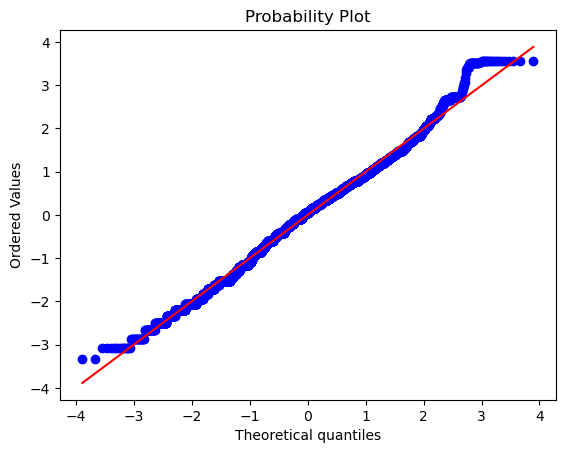

In [183]:
# After transformation
stats.probplot(df_columns_chosen["price"], plot=plt)

# Outliers

host_id


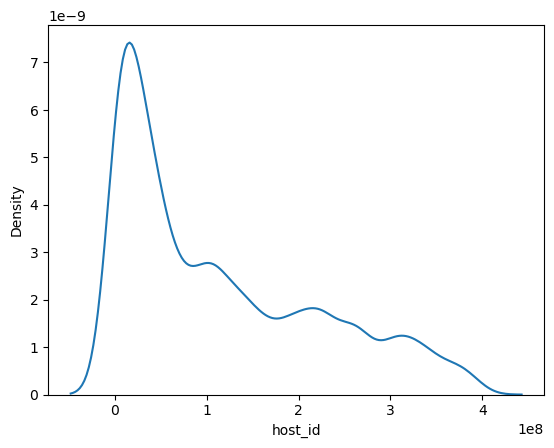

neighbourhood_group_cleansed


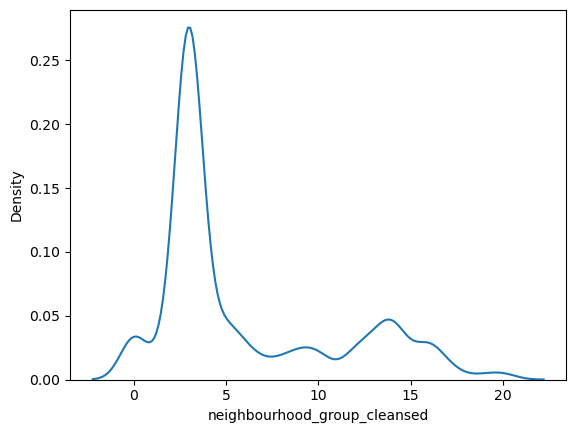

latitude


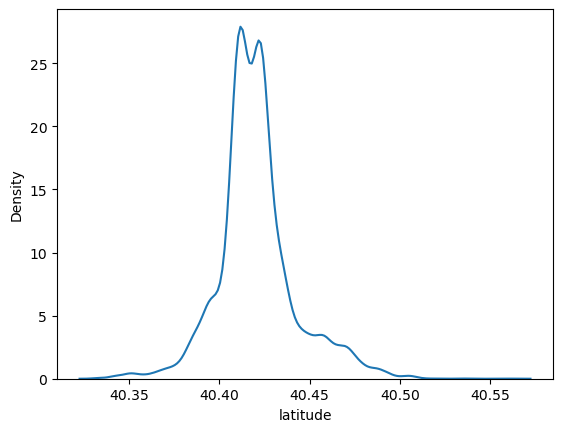

longitude


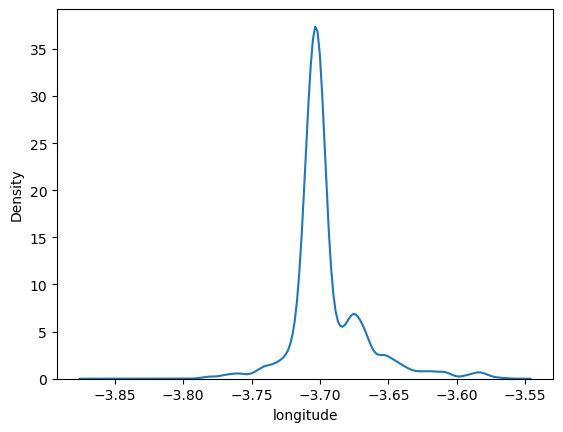

accommodates


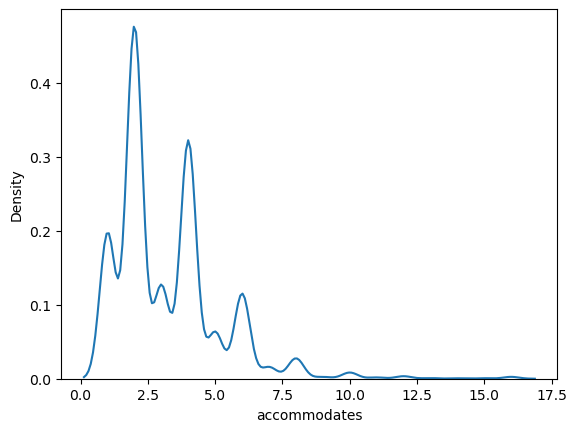

price


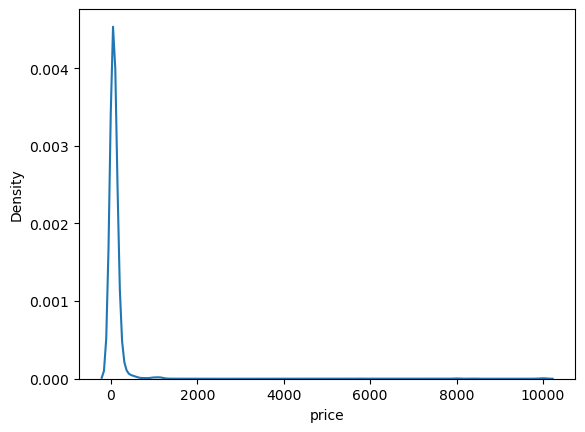

minimum_nights


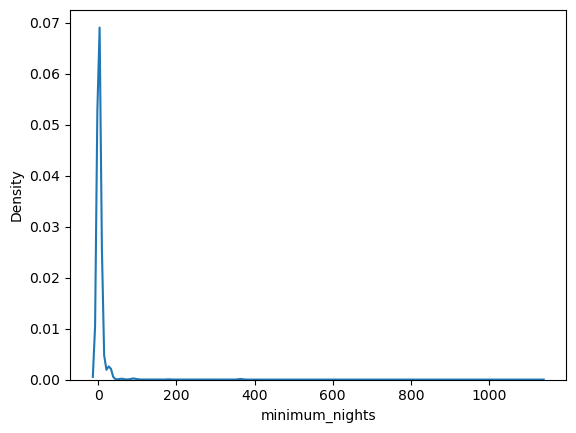

availability_365


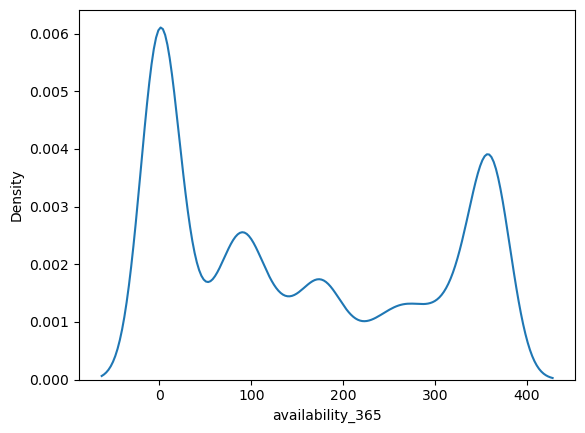

number_of_reviews


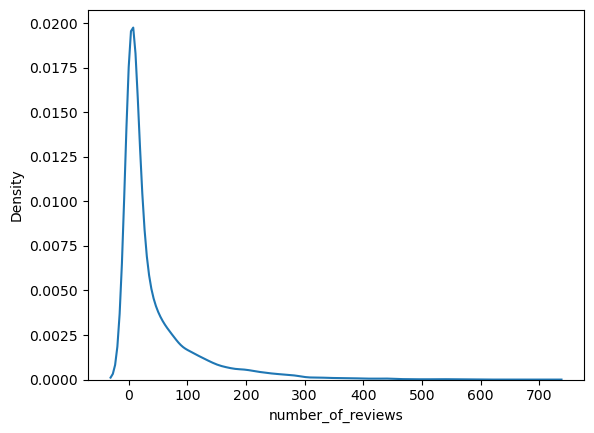

calculated_host_listings_count


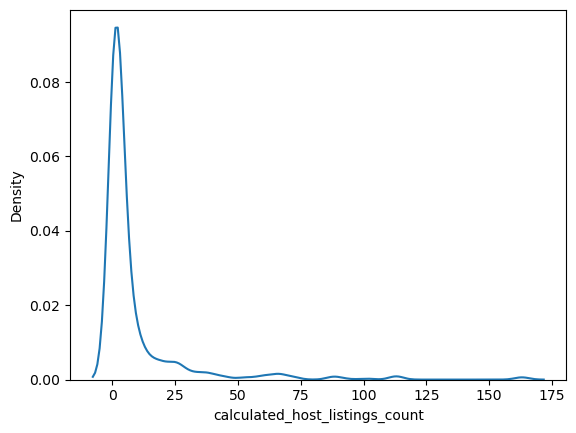

reviews_per_month


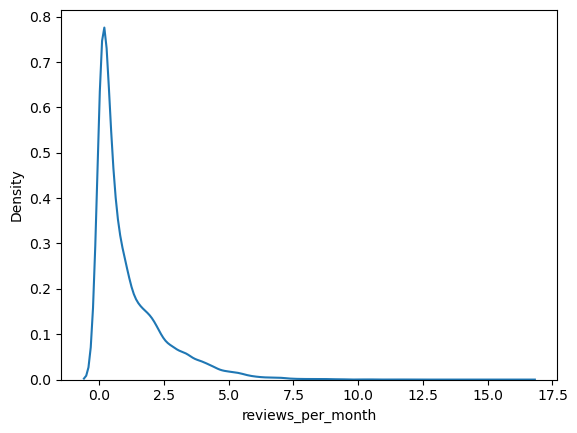

Hotel room


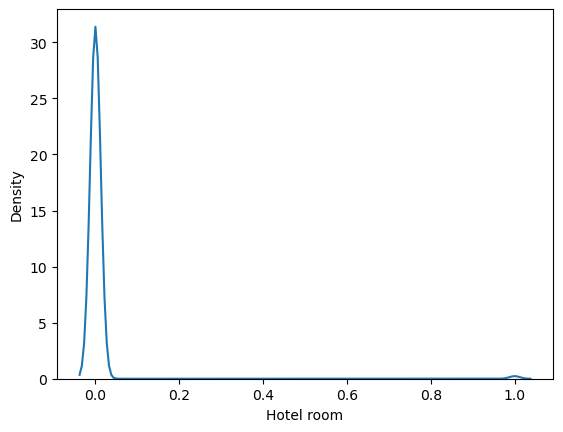

Private room


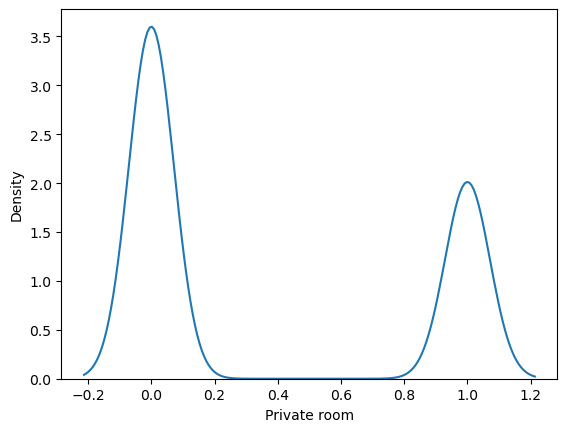

Shared room


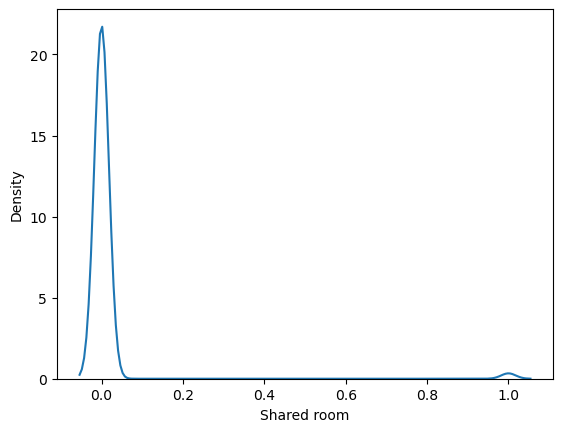

In [175]:
for i in df_columns_chosen.columns:
    
    print(i)
    sns.kdeplot(df_columns_chosen[i])
    plt.show()

In [227]:
df.shape

(18700, 21)

In [228]:
df = df[df["beds"]<15]

In [229]:
df.shape

(18686, 21)

In [230]:
df = df[df["accommodates"]<13]

In [231]:
df.shape

(18637, 21)

In [310]:
df = df[df["price"]<700]

<AxesSubplot:xlabel='price', ylabel='Count'>

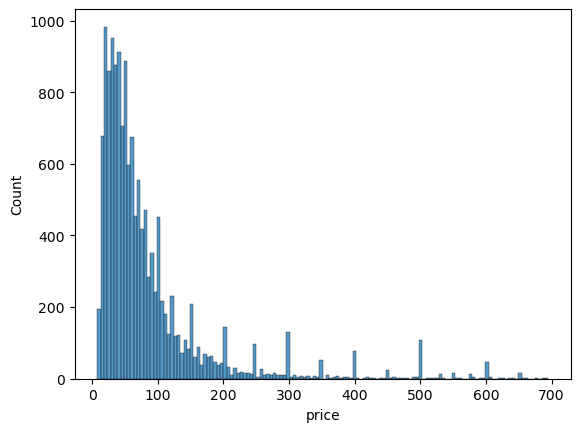

In [311]:
sns.histplot(df[df["host_is_superhost"] == 0]["price"])

<AxesSubplot:xlabel='price', ylabel='Count'>

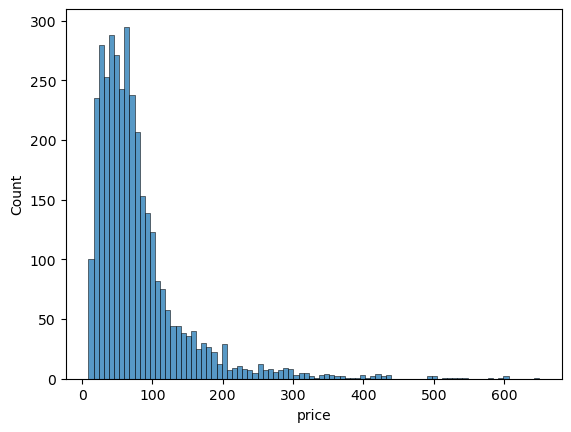

In [312]:
sns.histplot(df[df["host_is_superhost"] == 1]["price"])

In [233]:
df.shape

(18196, 21)

In [234]:
df = df[df["minimum_nights"]<150]

In [235]:
df.shape

(18110, 21)

In [236]:
df = df[df["maximum_nights"]<1500]

In [237]:
df.shape

(18105, 21)

In [238]:
df = df[df["number_of_reviews"]<500]

In [239]:
df.shape

(18082, 21)

In [240]:
df = df[df["amenities"]<1200]

In [241]:
df.shape

(18078, 21)

In [242]:
df = df[df["host_verifications"]<160]

In [243]:
df.shape

(18075, 21)

In [244]:
df = df[df["num_of_baths"] < 7]

In [245]:
df.shape

(18060, 21)

host_is_superhost


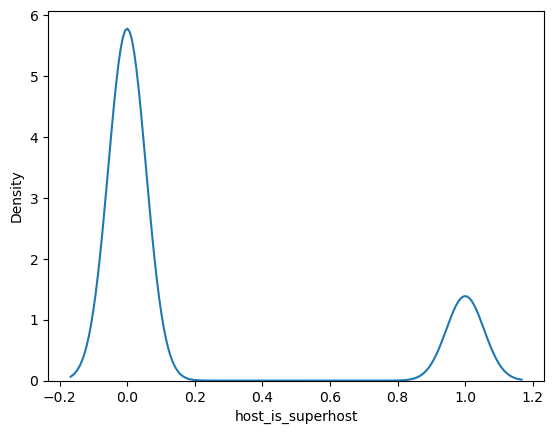

neighbourhood_cleansed


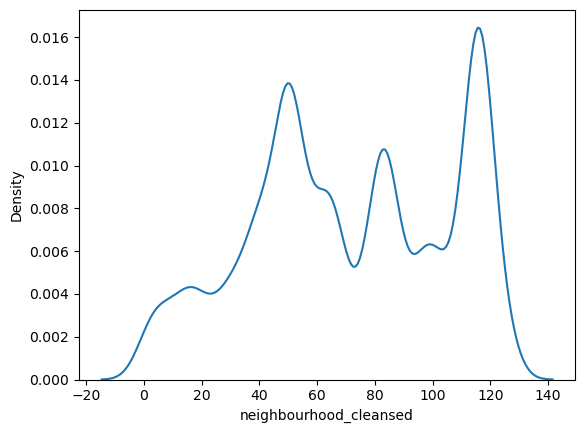

neighbourhood_group_cleansed


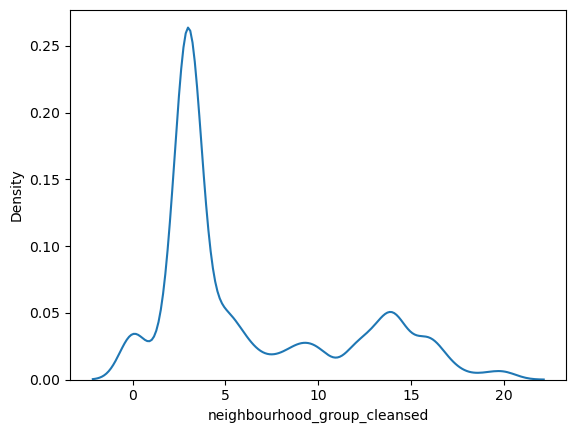

property_type


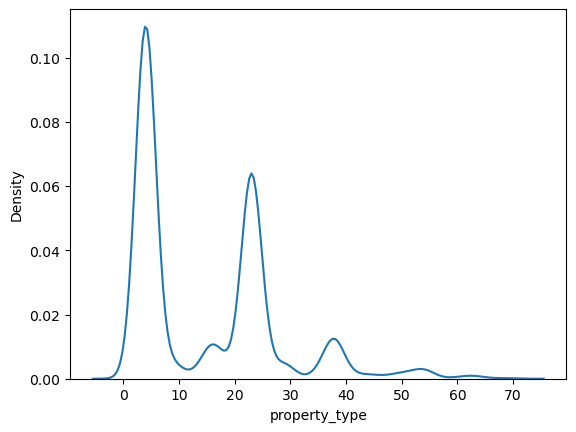

accommodates


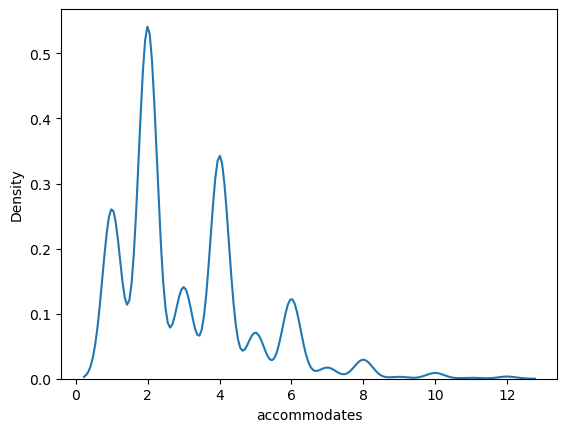

beds


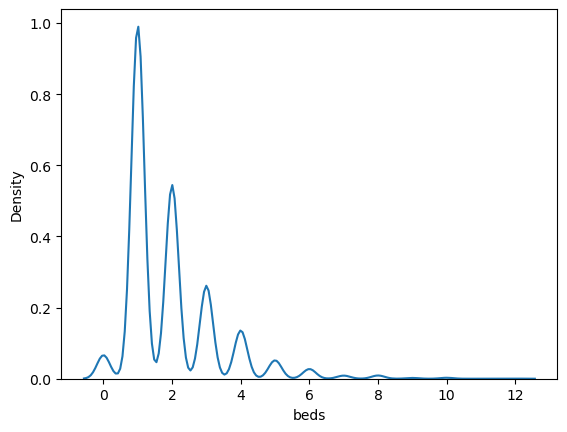

price


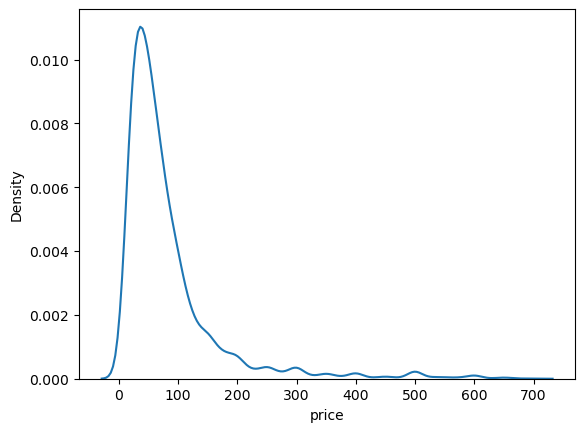

minimum_nights


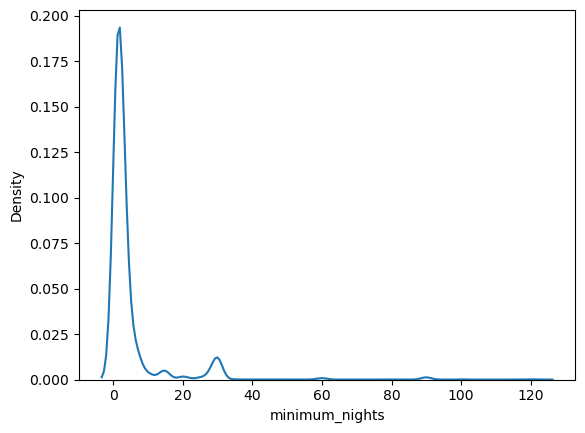

maximum_nights


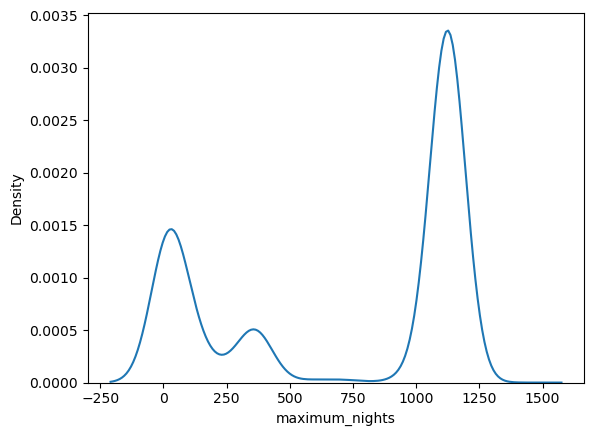

availability_30


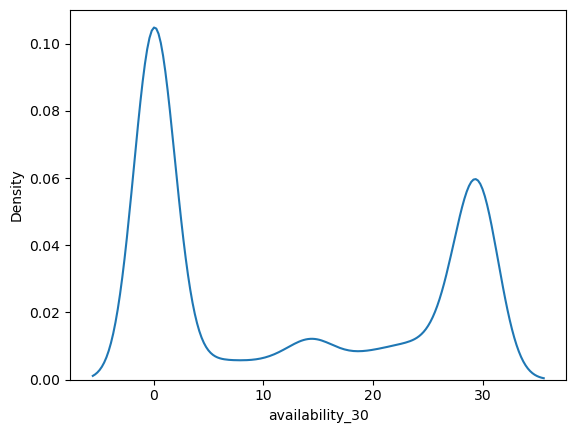

availability_365


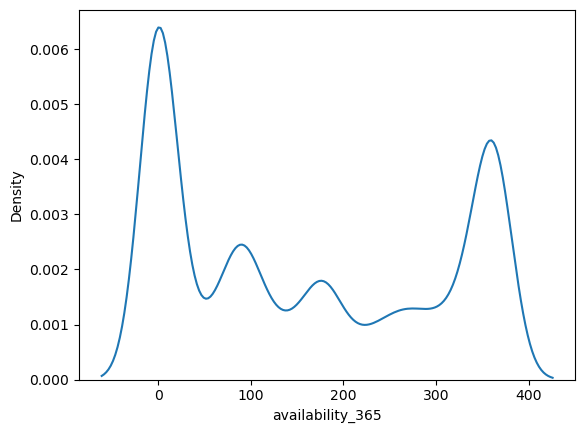

number_of_reviews


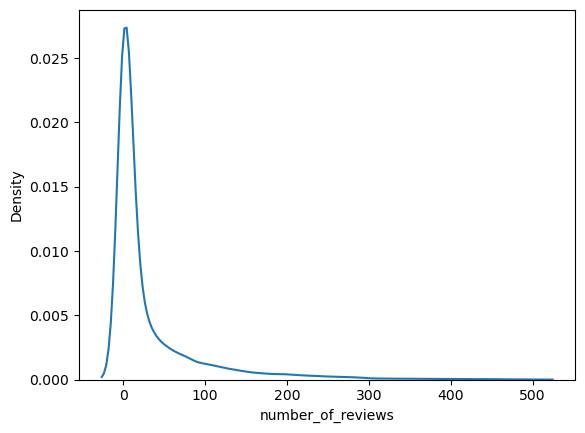

instant_bookable


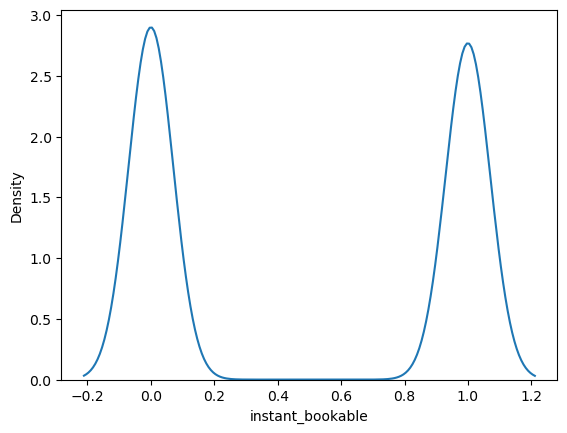

amenities


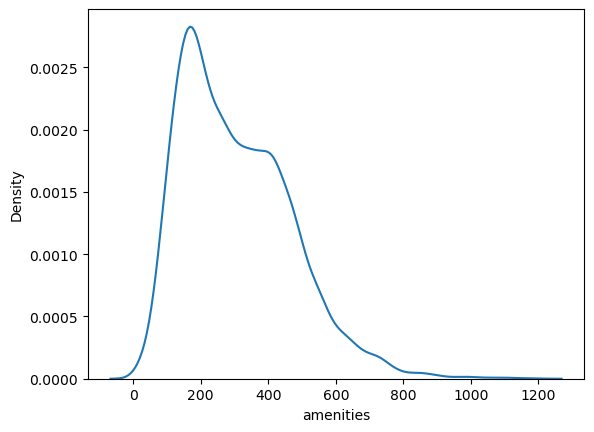

host_verifications


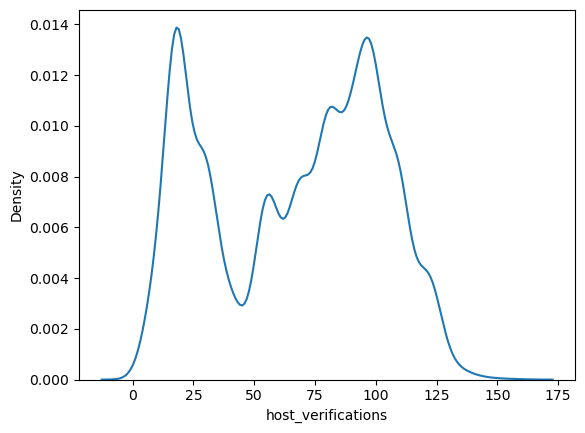

num_of_baths


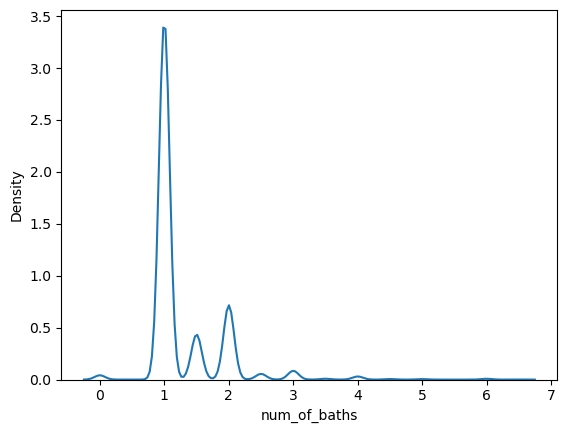

shared_bath


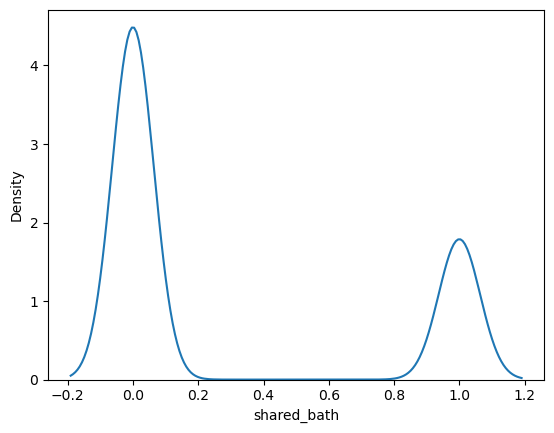

unknoun_bath


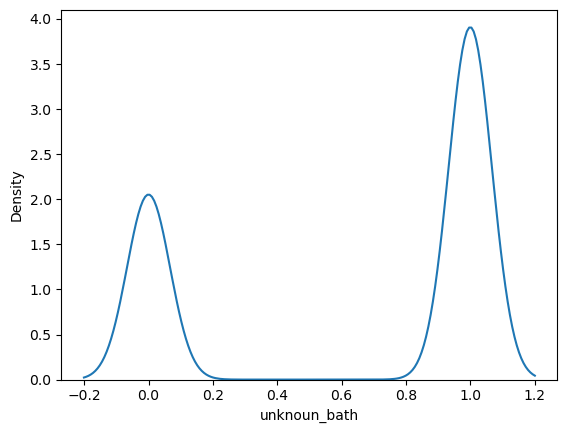

Hotel room


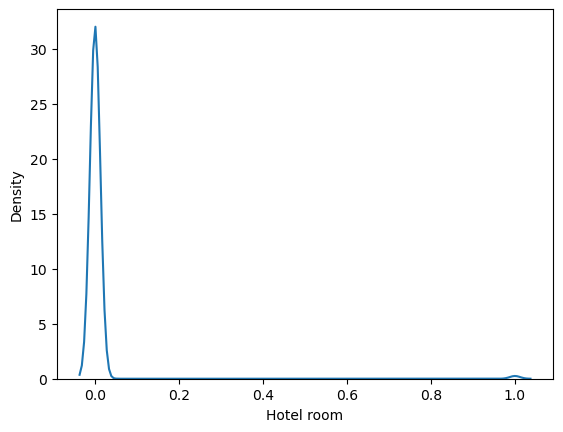

Private room


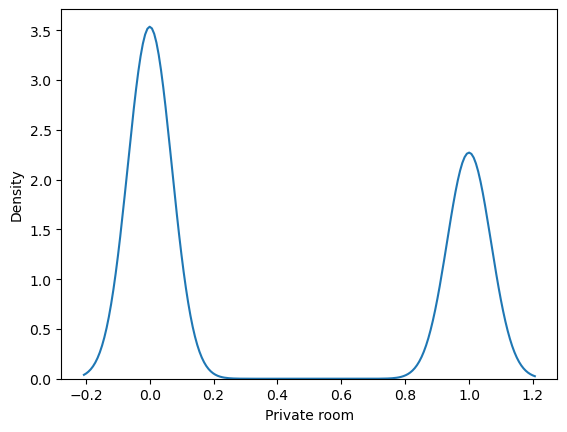

Shared room


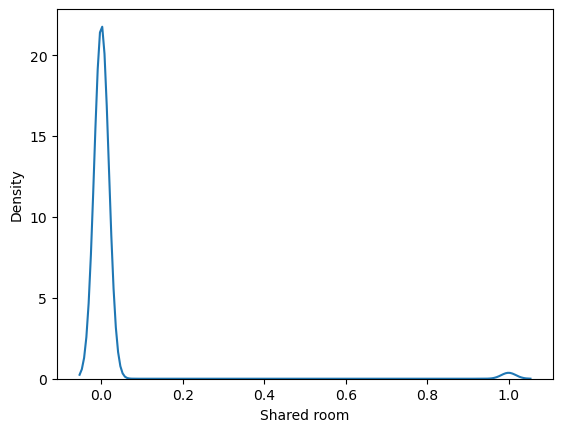

In [246]:
for i in df.columns:
    
    print(i)
    sns.kdeplot(df[i])
    plt.show()

## Dividing x & y

In [184]:
X = df_columns_chosen.drop("price", axis = 1)
y = df_columns_chosen[["price"]]


## Scaling data

In [185]:
from sklearn.preprocessing import MinMaxScaler


scaler_x = MinMaxScaler()
scaler_x.fit(X)
X = scaler_x.transform(X)


scaler_y = MinMaxScaler()
scaler_y.fit(y)
y = scaler_y.transform(y)

# Feature importances

In [145]:
df_class = df_columns_chosen["price"].copy()

In [146]:
df_columns_chosen.drop("price", axis = 1, inplace = True)

In [147]:
X = np.asarray(df_columns_chosen)
y = np.asarray(df_class)

In [148]:
X.shape, y.shape

((13981, 13), (13981,))

Feature ranking:
1. feature 0 (0.139062): host_id
2. feature 6 (0.138465): neighbourhood_group_cleansed
3. feature 9 (0.115405): latitude
4. feature 2 (0.114291): longitude
5. feature 7 (0.109515): accommodates
6. feature 8 (0.103777): minimum_nights
7. feature 3 (0.093539): availability_365
8. feature 5 (0.079172): number_of_reviews
9. feature 4 (0.056033): calculated_host_listings_count
10. feature 1 (0.037828): reviews_per_month
11. feature 11 (0.008448): Hotel room
12. feature 10 (0.003819): Private room
13. feature 12 (0.000645): Shared room


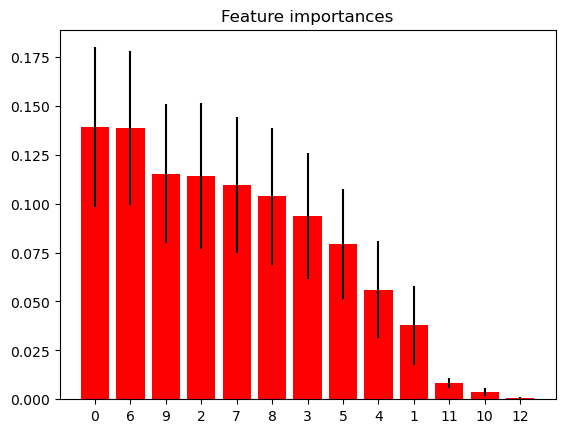

In [150]:
from sklearn.ensemble import ExtraTreesRegressor

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators = 250,
                              random_state = 0)

forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], df_columns_chosen.columns[f]))

# Plot the feature importances of the forest
plt.figure()

plt.title("Feature importances")

plt.bar(range(X.shape[1]), importances[indices], color = "r", yerr = std[indices], align = "center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# 1. LinearRegression

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data: {X_test.shape, y_test.shape}")

Train data: ((11184, 13), (11184, 1))
Test data: ((2797, 13), (2797, 1))


In [187]:
# Regresión algorithm

regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train, y_train)

# Finding coef

print ("weights:", regresion_lineal.coef_)
print ("w_0:", regresion_lineal.intercept_)

weights: [[-0.0127635  -0.02214245  0.11621585  0.00566939  0.27416606 -0.03487262
   0.01546601  0.05148201 -0.00484243 -0.1424056   0.04541774 -0.12021283
  -0.22092534]]
w_0: [0.43985987]


## Predicción

In [188]:
yhat = regresion_lineal.predict(X_test)

for i, j in zip(yhat[:5], y_test[:5]):
    print(f"Predicción:{i} \tValor real:{j}")

Predicción:[0.69328821] 	Valor real:[0.69149606]
Predicción:[0.37098283] 	Valor real:[0.50573553]
Predicción:[0.54806051] 	Valor real:[0.54682527]
Predicción:[0.33800423] 	Valor real:[0.39492462]
Predicción:[0.45359711] 	Valor real:[0.40714012]


## Metrics

In [189]:
# Sklearn tiene las formulas de algunas métricas en funciones.

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [190]:
# Relative Absolute Error
RAE = np.sum(np.abs(np.subtract(y_test, yhat))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))

# Relative Square Error
RSE = np.sum(np.square(np.subtract(y_test, yhat))) / np.sum(np.square(np.subtract(y_test, np.mean(y_test))))

# Adjusted R**2
r2_ajustada = 1 - (1 - regresion_lineal.score(X_test, y_test))*(len(y_test) - 1)/(len(y_test) - X_test.shape[1] - 1)

In [191]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.07152127679760144
MSE:	 0.009315055237589454
R**2:	 0.20248567133814677
RAE:	 0.6357515519146851
RSE:	 0.4516448604594825
Adjusted R**2:	 0.5462454078890719


In [192]:
# Veamos los valores de yhat, y_test y su diferencia

df_pred = pd.DataFrame()

df_pred["y_test"] = scaler_y.inverse_transform(y_test).flatten()
df_pred["yhat"] = scaler_y.inverse_transform(yhat).flatten()

df_pred["diferencia"] = round(abs((df_pred["y_test"] - df_pred["yhat"]) / df_pred["y_test"] * 100), 4)

df_pred = df_pred.sort_values("diferencia")

df_pred.head(20)

,y_test,yhat,diferencia
823,0.547901,0.546885,0.1855
1893,0.604521,0.605887,0.2260
2093,0.423129,0.424147,0.2407
1491,1.484831,1.481183,0.2457
1203,0.811845,0.809720,0.2619
1008,0.439659,0.438500,0.2637
2488,0.487587,0.485325,0.4639
2041,0.864504,0.868533,0.4661
61,0.644791,0.648426,0.5637
2367,-0.608044,-0.611701,0.6014


In [193]:
df_pred.tail(20)

,y_test,yhat,diferencia
2465,0.015917,0.499202,3036.3417
1995,0.015917,0.513598,3126.7875
987,0.015917,0.606108,3708.0013
1892,-0.009428,0.373742,4064.1854
2588,-0.009428,0.386250,4196.8524
1785,0.015917,0.746729,4591.4846
215,-0.009428,0.442198,4790.2809
597,0.015917,-0.772188,4951.4358
269,-0.009428,0.458928,4967.7333
2699,-0.009428,-0.481422,5006.3240


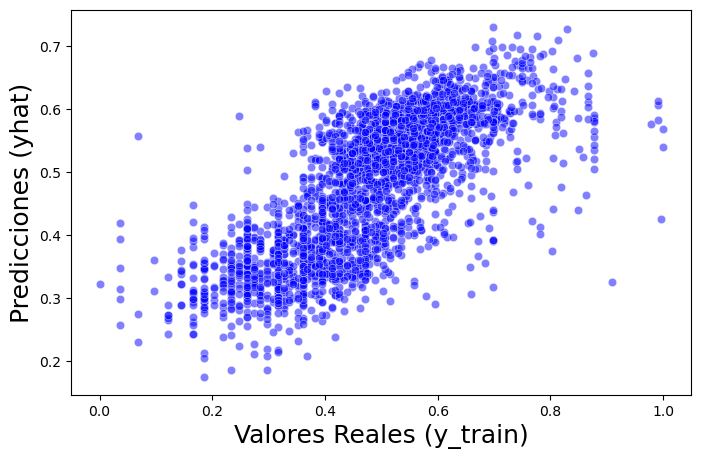

In [194]:
# Distance btw real and predicted values

plt.figure(figsize = (8, 5))

sns.scatterplot(x = y_test.flatten(), y = yhat.flatten(), alpha = 0.5, color = "blue")

plt.xlabel("Valores Reales (y_train)", size = 18)
plt.ylabel("Predicciones (yhat)", size = 18)

plt.show()

# 2. KNeighborsRegressor

In [195]:
from sklearn.neighbors import KNeighborsRegressor

In [196]:
model = KNeighborsRegressor(n_neighbors = 7)

model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [197]:
yhat = model.predict(X_test)

yhat

array([[0.65126042],
       [0.38160814],
       [0.49197679],
       ...,
       [0.50552912],
       [0.65713713],
       [0.19912474]])

In [198]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.07060123087850306
MSE:	 0.00911130003431331
R**2:	 0.2950893763006851
RAE:	 0.6357515519146851
RSE:	 0.4516448604594825
Adjusted R**2:	 0.5462454078890719


# 3. DecisionTreeRegressor

In [199]:
from sklearn.tree import DecisionTreeRegressor

In [200]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [201]:
yhat = model.predict(X_test)

yhat

array([0.59265475, 0.48897725, 0.53440576, ..., 0.40714012, 0.79112175,
       0.36005061])

In [202]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.08773106298456311
MSE:	 0.01532270862463694
R**2:	 0.27617400209546383
RAE:	 0.6357515519146851
RSE:	 0.4516448604594825
Adjusted R**2:	 0.5462454078890719


# 4. RandomForestRegressor

In [203]:
from sklearn.ensemble import RandomForestRegressor

In [204]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

C:\Users\ignci\AppData\Local\Temp\ipykernel_8628\3943944304.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestRegressor()

In [205]:
yhat = model.predict(X_test)

yhat

array([0.64495074, 0.41404308, 0.53782826, ..., 0.46375262, 0.68251147,
       0.27408439])

In [206]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.06121611084615303
MSE:	 0.007456660071798847
R**2:	 0.43159311877763373
RAE:	 0.6357515519146851
RSE:	 0.4516448604594825
Adjusted R**2:	 0.5462454078890719


# 4. AdaBoostRegressor

In [207]:
from sklearn.ensemble import AdaBoostRegressor

In [208]:
model = AdaBoostRegressor(n_estimators = 50)
model.fit(X_train, y_train)


C:\Users\ignci\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor()

In [209]:
yhat = model.predict(X_test)

yhat

array([0.62633092, 0.41486315, 0.5381462 , ..., 0.60333849, 0.61889834,
       0.39250744])

In [210]:
print(f"MAE:\t {mean_absolute_error(yhat, y_test)}")
print(f"MSE:\t {mean_squared_error(yhat, y_test)}")
print(f"R**2:\t {r2_score(yhat, y_test)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 0.09680851394676289
MSE:	 0.014740630236143063
R**2:	 -0.29518512793026375
RAE:	 0.6357515519146851
RSE:	 0.4516448604594825
Adjusted R**2:	 0.5462454078890719


In [211]:
model.base_estimator_

DecisionTreeRegressor(max_depth=3)

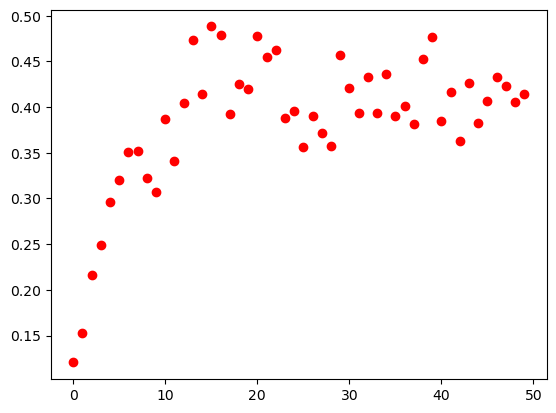

In [212]:
plt.plot(model.estimator_errors_, marker = "o", color = "red", linestyle = "")
plt.show()

In [213]:
model.feature_importances_

array([0.0766491 , 0.00851374, 0.11080968, 0.09338781, 0.16946633,
       0.01081481, 0.07765391, 0.07444356, 0.01181598, 0.05223956,
       0.01471137, 0.22439699, 0.07509717])

In [214]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

# Mapa

In [44]:
# df.columns

In [45]:
# df['neighbourhood_group_cleansed'].unique()

In [46]:
# with open("neighbourhoods.geojson", "r") as file:
    
#     geojson = file.read()
    
# pprint(geojson)

In [47]:
# df_map = df.groupby('neighbourhood_group_cleansed', as_index=False).mean()
# df_map

In [48]:
# df_map = df_map[df_map["price"]<200]

In [49]:
# df_map

In [50]:
# sns.histplot(df_map["price"])

In [51]:
# world_map = folium.Map(location = [40.18893909782826, -3.938873736090105], zoom_start =12)

# folium.Choropleth(geo_data     = geojson,
#                   data         = df_map,
#                   columns      = ["neighbourhood_group_cleansed", "price"],
#                   key_on       = "feature.properties.neighbourhood_group",
#                   fill_color   = "Blues_r", 
#                   fill_opacity = 0.7, 
#                   line_opacity = 0.2,
#                   legend_name  = "Precio airbnb",
#                   bins         = 253,
#                   highlight    = True).add_to(world_map)

# world_map